In [1]:
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plot
fitness_df = pd.read_csv("fitness_exercises.csv")

# Classifiers to test 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

Objective: Determine if a User needs to go to the gym or not to satisfy their fitness goals. Recommend corresponding exercises that fit the workout routines they want, and their desired fitness goals. 

# Section 1. Fitness Data -- EDA 

In [2]:
# Get a feel for the dataset by looking at first 10 entries
fitness_df.head()

,bodyPart,equipment,gifUrl,id,name,target
0,waist,body weight,http://d205bpvrqc9yn1.cloudfront.net/0001.gif,1,3/4 sit-up,abs
1,waist,body weight,http://d205bpvrqc9yn1.cloudfront.net/0002.gif,2,45° side bend,abs
2,waist,body weight,http://d205bpvrqc9yn1.cloudfront.net/0003.gif,3,air bike,abs
3,upper legs,body weight,http://d205bpvrqc9yn1.cloudfront.net/1512.gif,1512,all fours squad stretch,quads
4,waist,body weight,http://d205bpvrqc9yn1.cloudfront.net/0006.gif,6,alternate heel touchers,abs


In [3]:
# Data types of each of the columns 
print(fitness_df.dtypes)

bodyPart     object
equipment    object
gifUrl       object
id            int64
name         object
target       object
dtype: object


In [4]:
# Check for any null values within the columns 
print(fitness_df.isnull().sum())

bodyPart     0
equipment    0
gifUrl       0
id           0
name         0
target       0
dtype: int64


In [5]:
# Drop unnecessary columns of the dataframe
fitness_df = fitness_df.drop(columns=['gifUrl', 'id'])

In [6]:
# Check if there are any empty string entries in the remaining columns 
fitness_df.eq(" ").sum()

bodyPart     0
equipment    0
name         0
target       0
dtype: int64

In [7]:
# Take a look at how many unique values there are and the frequency of these values in the columns of the dataset 
# 1. Equipment 
fitness_df["equipment"].value_counts()

body weight             325
dumbbell                294
cable                   157
barbell                 154
leverage machine         84
band                     54
smith machine            48
kettlebell               41
weighted                 36
stability ball           28
ez barbell               23
sled machine             15
assisted                 15
medicine ball            13
rope                     10
roller                    8
resistance band           7
bosu ball                 3
wheel roller              2
olympic barbell           2
hammer                    1
skierg machine            1
upper body ergometer      1
stationary bike           1
tire                      1
trap bar                  1
elliptical machine        1
stepmill machine          1
Name: equipment, dtype: int64

In [8]:
# 2. Target -- this column contains the target muscle area that a specific exercise in the dataset may work best for 
fitness_df["target"].value_counts()

abs                      170
pectorals                159
biceps                   151
glutes                   144
delts                    144
triceps                  141
upper back                88
lats                      81
calves                    59
quads                     44
forearms                  37
cardiovascular system     29
hamstrings                28
spine                     19
traps                     15
adductors                  6
serratus anterior          5
abductors                  5
levator scapulae           2
Name: target, dtype: int64

In [9]:
# 3. Bodypart -- part associated with particular exercise 
fitness_df["bodyPart"].value_counts()

upper arms    292
upper legs    227
back          203
waist         170
chest         164
shoulders     144
lower legs     59
lower arms     37
cardio         29
neck            2
Name: bodyPart, dtype: int64

In [10]:
#ADD these columns: Strengthen Core, Upper Body Gains,Bigger Booty,Stronger Legs, Gym(0 no, 1 yes)

In [11]:
# Renaming of columns so it is easier to work with 
fitness_df = fitness_df.rename(columns={'name':'Exercise', 'bodyPart': 'Bodypart', 'equipment': 'Equipment', 'target': 'Target'})

In [12]:
# Take a look at dataset structure 
fitness_df.head()

,Bodypart,Equipment,Exercise,Target
0,waist,body weight,3/4 sit-up,abs
1,waist,body weight,45° side bend,abs
2,waist,body weight,air bike,abs
3,upper legs,body weight,all fours squad stretch,quads
4,waist,body weight,alternate heel touchers,abs


# Section 2. Fitness Data -- Feature Engineering & Encoding
External Links to resources we used to determine what exercises constituted the below fitness goals: strengthen core, upper body gains, bigger booty, stronger legs
https://www.fitnessblender.com/videos/all-strength-upper-body-workout-upper-body-muscle-building-workout#:~:text=To%20do%20this%20we%20focused,(front%20of%20upper%20arm).
https://www.shape.com/fitness/tips/butt-muscles-guide
https://www.mayoclinic.org/healthy-lifestyle/fitness/multimedia/core-strength/sls-20076575
https://www.eatingwell.com/article/7917613/exercises-to-improve-balance/#:~:text=To%20improve%20your%20stability%2C%20you,keep%20the%20hips%20in%20alignment.

External link to resources we used to determine workout routine category (abs, push, pull, legs) 
https://legionathletics.com/push-pull-legs/

## Fitness Goals 
1. Strengthen Core 
2. Upper Body Gains 
3. Bigger Booty 
4. Stronger Legs
5. Build Muscle Strength 
6. Improve Balance

0 --- Exercise does not fulfill particular fitness goal 
1 --- Exercise does fulfill particular fitness goal 

## Gym Access
 0 --- You do not need access to a gym for this exercise 
 1 -- You do need access to a gym for this exercise 

In [13]:
# Feature Engineering: New Columns to assess Gym Access, and Fitness Goals 
# Automatically set to zero initially 
fitness_df['Gym'] = 0
fitness_df['Strengthen Core'] = 0
fitness_df['Upper Body Gains'] = 0
fitness_df['Bigger Booty'] = 0
fitness_df['Stronger Legs'] = 0
fitness_df['Build Muscle Strength'] = 0 
fitness_df['Improve Balance'] = 0 

In [14]:
# Take a look at the dataset now 
fitness_df.head()

,Bodypart,Equipment,Exercise,Target,Gym,Strengthen Core,Upper Body Gains,Bigger Booty,Stronger Legs,Build Muscle Strength,Improve Balance
0,waist,body weight,3/4 sit-up,abs,0,0,0,0,0,0,0
1,waist,body weight,45° side bend,abs,0,0,0,0,0,0,0
2,waist,body weight,air bike,abs,0,0,0,0,0,0,0
3,upper legs,body weight,all fours squad stretch,quads,0,0,0,0,0,0,0
4,waist,body weight,alternate heel touchers,abs,0,0,0,0,0,0,0


In [15]:
# Manual Assignment of Label based on key words in Exercises 
# Here we come up with a list of keywords (based on some fitness research online) 
# keywords correspond to gym access or to a particular fitness goal user may have 

# Lists for storage of 0 or 1 for feature evaluation 
lst1 = []
lstcore = []
lstupbod = []
lstbigbutt = []
lststronglegs = []
lstmusclestrength = [] 
lstbalance = []

# Gym and Fitness goal keywords (informed manual assignment from existing literature)
# Gym -- Equipment based keywords 
need_gym = ['cable','barbell','leverage machine','smith machine','stability ball','ez barbell','assisted','sled machine','rope','bosu ball','olympic barbell','skierg machine','hammer','elliptical machine','stepmill machine','stationary bike','tire','trap bar','upper body ergometer']
core_exercises = ['abs','spine']
# Fitness Goals -- Target muscle area based keywords 
upper_bod = ['pectorals', 'biceps','delts','triceps','upper back','lats','forearms','traps','serratus anterior','levator scapulae']
big_butt = ['glutes','quads','hamstrings']
strong_legs = ['glutes','quads','hamstrings','adductors','abductors','calves']
balance = ['glutes', 'quads', 'hamstrings', 'calves', 'abs', 'abductors']
# these would be keywords where you would not necessarily build muscle strength
# see corresponding for loop for build_strength below 
build_strength = ['cardiovascular system', 'spine'] 

# the following are a series of for loops to evaluate if a particular exercise contains keywords from each grouping
# --- Gym Access ---
for index, row in fitness_df.iterrows():
    if row['Equipment'] in need_gym:
        lst1.append(1)
    else:
        lst1.append(0)
# --- Strengthen Core ---
for index, row in fitness_df.iterrows():
    if row['Target'] in core_exercises:
        lstcore.append(1)
    else:
        lstcore.append(0)
# --- Upper Body Gains ---
for index, row in fitness_df.iterrows():
    if row['Target'] in upper_bod:
        lstupbod.append(1)
    else:
        lstupbod.append(0)
# --- Bigger Booty ---
for index, row in fitness_df.iterrows():
    if row['Target'] in big_butt:
        lstbigbutt.append(1)
    else:
        lstbigbutt.append(0)
# --- Stronger Legs ----
for index, row in fitness_df.iterrows():
    if row['Target'] in strong_legs:
        lststronglegs.append(1)
    else:
        lststronglegs.append(0)
# --- Improve Balance --- 
for index, row in fitness_df.iterrows():
    if row['Target'] in balance:
        lstbalance.append(1)
    else:
        lstbalance.append(0)
# ---- Build Muscle Strength ---
for index, row in fitness_df.iterrows():
    if row['Target'] not in build_strength:
        lstmusclestrength.append(1)
    else:
        lstmusclestrength.append(0)

In [16]:
# Now that we have lists formed, set those lists into the feature columns 
# Now we have info about gym and fitness goals associated with exercises 
fitness_df["Gym"] = lst1 
fitness_df["Strengthen Core"] = lstcore
fitness_df["Upper Body Gains"] = lstupbod
fitness_df["Bigger Booty"] = lstbigbutt
fitness_df["Stronger Legs"] = lststronglegs
fitness_df["Build Muscle Strength"] = lstmusclestrength
fitness_df["Improve Balance"] = lstbalance

In [17]:
# Look at the dataset 
fitness_df

,Bodypart,Equipment,Exercise,Target,Gym,Strengthen Core,Upper Body Gains,Bigger Booty,Stronger Legs,Build Muscle Strength,Improve Balance
0,waist,body weight,3/4 sit-up,abs,0,1,0,0,0,1,1
1,waist,body weight,45° side bend,abs,0,1,0,0,0,1,1
2,waist,body weight,air bike,abs,0,1,0,0,0,1,1
3,upper legs,body weight,all fours squad stretch,quads,0,0,0,1,1,1,1
4,waist,body weight,alternate heel touchers,abs,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1322,chest,body weight,wide-grip chest dip on high parallel bars,pectorals,0,0,1,0,0,1,0
1323,waist,body weight,wind sprints,abs,0,1,0,0,0,1,1
1324,upper legs,body weight,world greatest stretch,hamstrings,0,0,0,1,1,1,1
1325,lower arms,body weight,wrist circles,forearms,0,0,1,0,0,1,0


## Workout Routines 

1. Ab Workouts: target the abs 

2. Push Workouts: target upper body areas and muscle groups such as chest, shoulders, triceps, and arms 

3. Pull Workouts: Back, biceps, hamstrings, glutes, etc. 

4. Leg Workouts: Legs, quads, calves 

5. Cardio Workouts: Cardio 

6. Neck Workouts: Neck

In [18]:
# Now we want to use workout routine as a feature 
# Function to condense and assign numerical labels to exercise rows 
def workout_numbering(row):
    if row["Target"] == "abs":
        # 'Ab workouts'
        # numeric category: 
        return 1 
    if row["Bodypart"] == "chest" or row["Bodypart"] == "shoulders":
      #'Push workouts'
        # numeric category: 
        return 2
    if row["Bodypart"] == "lower arms" or row["Bodypart"] == "upper arms":
      #'Push workouts' 
        # numeric category: 
        return 2
    if row['Bodypart'] == "back":
      #'Pull workouts'
        # numeric category: 
        return 3
    if row["Bodypart"] == "lower legs" or row["Bodypart"] == "upper legs":
    # 'Leg workouts'
    # numeric category:
        return 4 
    if row["Bodypart"] == "cardio":
        # 'cardio workouts'
        # numeric category:
        return 5 
    if row["Bodypart"] == "neck":
        # 'neck workouts'
        # numeric category:
        return 6
    elif row["Target"] == "triceps" or row["Target"] == "pectorals":
      #'Push workouts' 
        # numeric category: 
        return 2
    elif row["Target"] == "biceps" or row["Target"] == "hamstrings" or row["Target"] == "glutes":
    # 'Pull workouts'
    # numeric category: 
        return 3
    elif row["Target"] == "quads" or row["Target"] == "calves":
    # 'Leg workouts'
    # numeric category
       return 4
    # default "Other" category gets numeric label -- 8
    return 7

# apply this function to eacah of the rows in the dataset 
# verify that the output looks good before making a new column based on returns
fitness_df.apply(lambda row: workout_numbering(row), axis=1)

0       1
1       1
2       1
3       4
4       1
       ..
1322    2
1323    1
1324    4
1325    2
1326    2
Length: 1327, dtype: int64

In [19]:
# Make new column for "Body Area" -- with the numeric categories 
fitness_df['Workout Category'] = fitness_df.apply (lambda row: workout_numbering(row), axis=1)

In [20]:
# Change to more general name prior to entering into the modeling phase
df = fitness_df
df

,Bodypart,Equipment,Exercise,Target,Gym,Strengthen Core,Upper Body Gains,Bigger Booty,Stronger Legs,Build Muscle Strength,Improve Balance,Workout Category
0,waist,body weight,3/4 sit-up,abs,0,1,0,0,0,1,1,1
1,waist,body weight,45° side bend,abs,0,1,0,0,0,1,1,1
2,waist,body weight,air bike,abs,0,1,0,0,0,1,1,1
3,upper legs,body weight,all fours squad stretch,quads,0,0,0,1,1,1,1,4
4,waist,body weight,alternate heel touchers,abs,0,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1322,chest,body weight,wide-grip chest dip on high parallel bars,pectorals,0,0,1,0,0,1,0,2
1323,waist,body weight,wind sprints,abs,0,1,0,0,0,1,1,1
1324,upper legs,body weight,world greatest stretch,hamstrings,0,0,0,1,1,1,1,4
1325,lower arms,body weight,wrist circles,forearms,0,0,1,0,0,1,0,2


# Section 3. Supervised Learning Model

#### Features: Fitness Goals and Workout Category 
#### Target: Gym Access

In [21]:
#partition the data
# for features we consider fitness goals as well
# We tried this model with the numerical encoding for Body Area as well but unfortunately it did not change much for us 
feature_columns = ['Strengthen Core','Upper Body Gains', 'Bigger Booty', 'Stronger Legs',
       'Build Muscle Strength', 'Improve Balance', "Workout Category"]
X   = df[feature_columns] #get the input features
y   = df['Gym'] #get the target: we want to evaluate if the particular exercise requires gym access or not 

X_train, X_test, y_train, y_test = train_test_split(X,              #the input features
                                                    y,              #the label
                                                    test_size=0.3,  #set aside 30% of the data as the test set
                                                    random_state=7, #reproduce the results
                                                   )

## Random Forest Model 

In [22]:
#build the classifier
rf = RandomForestClassifier(criterion='entropy', n_estimators = 50, random_state = 7)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=50, random_state=7)

In [23]:
#predict the labels for the test set
y_pred   = rf.predict(X_test)

y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [24]:
# Prediction accuracy
print('The accuracy of the model is: {}'.format(rf.score(X_test, y_test)))

The accuracy of the model is: 0.6265664160401002


## SVM Model 

In [25]:
X_train = X_train.copy()
X_test  = X_test.copy()

In [26]:
X_train.head()

,Strengthen Core,Upper Body Gains,Bigger Booty,Stronger Legs,Build Muscle Strength,Improve Balance,Workout Category
1311,0,1,0,0,1,0,2
773,0,1,0,0,1,0,3
530,0,1,0,0,1,0,2
492,0,1,0,0,1,0,2
244,0,1,0,0,1,0,3


In [27]:
#normalize the numeric features
scaler = StandardScaler()
scaler.fit(X_train[feature_columns])

X_train[feature_columns] = scaler.transform(X_train[feature_columns]) #scale the training data

In [28]:
# take a look at the normalized, prepared data
X_train.head(10)

,Strengthen Core,Upper Body Gains,Bigger Booty,Stronger Legs,Build Muscle Strength,Improve Balance,Workout Category
1311,-0.407221,0.805179,-0.456435,-0.542477,0.197974,-0.737627,-0.529097
773,-0.407221,0.805179,-0.456435,-0.542477,0.197974,-0.737627,0.418784
530,-0.407221,0.805179,-0.456435,-0.542477,0.197974,-0.737627,-0.529097
492,-0.407221,0.805179,-0.456435,-0.542477,0.197974,-0.737627,-0.529097
244,-0.407221,0.805179,-0.456435,-0.542477,0.197974,-0.737627,0.418784
25,2.455668,-1.241960,-0.456435,-0.542477,0.197974,1.355699,-1.476978
1181,-0.407221,0.805179,-0.456435,-0.542477,0.197974,-0.737627,-0.529097
452,-0.407221,-1.241960,2.190890,1.843395,0.197974,1.355699,1.366664
222,-0.407221,-1.241960,2.190890,1.843395,0.197974,1.355699,1.366664
704,-0.407221,0.805179,-0.456435,-0.542477,0.197974,-0.737627,-0.529097


In [29]:
#initialize the classifier

svm = SVC() #the default kernel is rbf
svm.fit(X_train, y_train) #fit the data

SVC()

In [30]:
X_test

,Strengthen Core,Upper Body Gains,Bigger Booty,Stronger Legs,Build Muscle Strength,Improve Balance,Workout Category
263,1,0,0,0,1,1,1
141,0,1,0,0,1,0,2
51,0,1,0,0,1,0,2
241,0,1,0,0,1,0,2
897,0,1,0,0,1,0,2
...,...,...,...,...,...,...,...
58,1,0,0,0,1,1,1
687,0,1,0,0,1,0,2
454,1,0,0,0,1,1,1
462,0,1,0,0,1,0,2


In [31]:
#encode & scale the new/test data
X_test[feature_columns] = scaler.transform(X_test[feature_columns]) #scale the test data
#predict the labels for the test set
y_pred   = svm.predict(X_test)

print('The predicted exercise is: {}'.format(y_pred))

The predicted exercise is: [0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0
 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


In [32]:
print("The acccuracy of the model is: {}".format(svm.score(X_test, y_test)))

The acccuracy of the model is: 0.6290726817042607


In [33]:
# Comparing the Two models 
names = ["Random Forest", "SVM"]
accuracies = [rf.score(X_test, y_test), svm.score(X_test, y_test)]

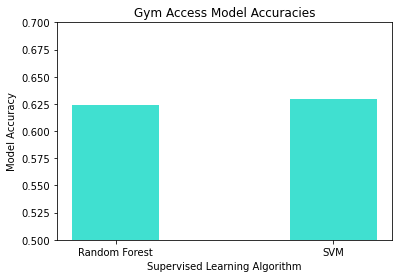

In [34]:
# creating the bar plot: Random Forest vs. SVM 
plot.bar(names, accuracies, color ='turquoise',
        width = 0.4)
 
plot.ylim(0.5, 0.7)
plot.xlabel("Supervised Learning Algorithm")
plot.ylabel("Model Accuracy")
plot.title("Gym Access Model Accuracies")
plot.show()

Analysis: The accuracy of the SVM model was slightly higher so we decided to go with that model to determine if a user would need access to a gym or not to satisfy their fitness goals. 

# Section 4. User Gym Access Assessment

### User Questionnaire 

In [35]:
# Question 1: What are your fitness goals? 
user_dict = {} # user dictionary of attributes 
# user fitness goals: answer key dictionary 
fit_dict = {"A": ["Strengthen Core"], "B": ["Upper Body Gains"], "C": ["Bigger Booty"], 
            "D": ["Stronger Legs"],  "E": ["Build Muscle Strength"], "F": ["Improve Balance"]}
# User's feature data collected 
print("What are your fitness goals? \n Please enter the letters of all that apply:")
print("\n A) Strengthen core \n B) Upper body gains \n C) Bigger booty")
print("\n D) Stronger legs \n E) Build muscle strength \n F) Improve Balance ") 
fit_goals = input(" ")

What are your fitness goals? 
 Please enter the letters of all that apply:

 A) Strengthen core 
 B) Upper body gains 
 C) Bigger booty

 D) Stronger legs 
 E) Build muscle strength 
 F) Improve Balance 
 AD


In [36]:
# Question 2: What type of workout routine are you most interested in (pick one number)? 
# user body part goals: answer key dictionary 
bp_goals = 9 # initialize 
while bp_goals > 7:
    # User's feature data collected 
    print("What type of workout routine would you most prefer (pick one number)? ")
    print("\n 1) Abs workouts \n 2) Push workouts \n 3) Pull workouts")
    print("\n 4) Leg workouts \n 5) Cardio workouts \n 6) Neck workouts \n 7) Other workouts") 
    bp_goals = int(input(" "))
    if bp_goals > 7:
        print("Something went wrong, please re-enter or press '0' to break the program")
    if bp_goals == 0:
        break 

What type of workout routine would you most prefer (pick one number)? 

 1) Abs workouts 
 2) Push workouts 
 3) Pull workouts

 4) Leg workouts 
 5) Cardio workouts 
 6) Neck workouts 
 7) Other workouts
 1


In [37]:
def user_labels(d, user_d, user_input):
    # function that takes in a dictionary of multiple choice question letters selected by a user [keys]
    # with their corresponding associated column names [dictionary values]
    # goes through columns of user dictionary and adjusts dummy values according to responses (0 or 1)
    # this function employs the re library and the search function to pick out
    # a piece of a desired string [letter] from user response, to characterize the user 
    # updates the user dictionary accordingly and returns the new copy to user 
    # method = 1: if value not found in string for a specific column, set column value to 0
    # if user manually inputs number other than 1 --- column value not automatically set to 0 as alternative
    for k, v in d.items():
        k_str = (k + "|" + k.lower()) # concactenate string for search 
        for value in v: # search through user's answer for key letter (k_str)
            if re.search(k_str, user_input): 
                user_d[value] = 1 # set specific colum for that feature --> 1
            else: 
                user_d[value] = 0 # set specific column for that feature --> 0
    return user_d 

In [38]:
# Make user dictionary with their fitness goals (first part of features)
user_dict = user_labels(fit_dict, user_dict, fit_goals)

In [39]:
user_dict["Workout Category"] = bp_goals 

In [40]:
# convert user input into dataframe 
user_inputs = pd.DataFrame([user_dict])
user_inputs

,Strengthen Core,Upper Body Gains,Bigger Booty,Stronger Legs,Build Muscle Strength,Improve Balance,Workout Category
0,1,0,0,1,0,0,1


In [41]:
# Model outcome -- user prediction 
y_pred   = svm.predict(user_inputs)

# Output statement to user
if y_pred[0] == 0:
    print("We predict that you will not need access to a gym to reach your fitness goals!")
elif y_pred[0] == 1:
    print("We predict that you will need access to a gym to reach your fitness goals!")

We predict that you will not need access to a gym to reach your fitness goals!


# Section 5. User Exercise Recommendations

## Filtration based on: 
- Gym access recommendation just generated 
- User desired workout routine 

In [42]:
user_df = df 
# filter out activities on opposite gym recommendation
user_gym = y_pred[0] # value that the user inputted for specific feature 
user_df = user_df[user_df["Gym"] == user_gym] # only leave df with user input values 

In [43]:
# examine their desired workout routine 
user_workout = user_inputs["Workout Category"].values[0] # their desired workout selected 
user_wk_df = user_df[user_df["Workout Category"] == user_workout] # dataframe to only contain rows with workout
count_row = user_wk_df.shape[0]  # Gives number of rows

In [44]:
print("Thank you for answering our questions!! Below are our fitness exercies recommendations to you!")
print("Here are the recommended exercises with the corresponding equipment needed, target muscle, and bodypart.")
if y_pred[0] == 1:
    print("Please note that these require a gym to be able to complete!")

Thank you for answering our questions!! Below are our fitness exercies recommendations to you!
Here are the recommended exercises with the corresponding equipment needed, target muscle, and bodypart.


In [45]:
# find and save all the fitness goal columns for which they answered yes 
fitness_goals = ['Strengthen Core','Upper Body Gains', 'Bigger Booty', 'Stronger Legs',
       'Build Muscle Strength', 'Improve Balance']
saved_cols = [] # initialized list 
for col in fitness_goals: 
    # if user selected yes, interested for that particular goal 
    if user_inputs[col].values[0] == 1:
        saved_cols.append(col)

In [46]:
saved_cols

['Strengthen Core', 'Stronger Legs']

## User Output Blocks 

In [47]:
print("Thank you for answering our questions!!")
print("Based on your fitness goals and desired workout we have generated a list of some more exercises that you could try!")
print("Here are the recommended exercises with the corresponding equipment needed, and target muscle")
if y_pred[0] == 1:
    print("Please note that these require a gym to be able to complete!")

Thank you for answering our questions!!
Based on your fitness goals and desired workout we have generated a list of some more exercises that you could try!
Here are the recommended exercises with the corresponding equipment needed, and target muscle


#### For loop to identify 5 random exercises in the desired workout routine, that fulfill some fitness goals of the user 

In [48]:
noentry_count = 0 # initialize; this is a check if there is a conflict between fitness goals / desired workout

for col in saved_cols: 
    # if user selected yes, interested for that particular goal 
    user_value = user_inputs[col].values[0] # 1 for user 
    filtered_df = user_wk_df[user_wk_df[col] == user_value] # filter out any non one rows 
    # pick five random activities that may have that may reach that fitness goal 
    # that haven't been chosen for recommendation yet [if five are available]
    count_row = filtered_df.shape[0]  # Gives number of rows
    if count_row > 4: 
        print("For your Fitness Goal:", col, ", we recommend these possible exercises:")
        outcome = filtered_df.sample(n = 5) 
        fit_recs = outcome[[ "Exercise", "Equipment", "Target"]]
        print(fit_recs.to_string(index=False))
    elif count_row == 0:
        noentry_count += 1 # add to count of fitness goal not met by workout plan  
    else: 
        print("For your Fitness Goal:", col, ", we recommend these possible exercises:")
        outcome = filtered_df 
        fit_recs = outcome[[ "Exercise", "Equipment", "Target"]]
        print(fit_recs.to_string(index=False))

For your Fitness Goal: Strengthen Core , we recommend these possible exercises:
                        Exercise   Equipment Target
                 roller body saw      roller    abs
               power point plank body weight    abs
   band standing twisting crunch        band    abs
      kettlebell double windmill  kettlebell    abs
weighted russian twist (legs up)    weighted    abs


In [49]:
# User recommended fitness goals as a dataframe 
outcome

,Bodypart,Equipment,Exercise,Target,Gym,Strengthen Core,Upper Body Gains,Bigger Booty,Stronger Legs,Build Muscle Strength,Improve Balance,Workout Category
1104,waist,roller,roller body saw,abs,0,1,0,0,0,1,1,1
1057,waist,body weight,power point plank,abs,0,1,0,0,0,1,1,1
84,waist,band,band standing twisting crunch,abs,0,1,0,0,0,1,1,1
884,waist,kettlebell,kettlebell double windmill,abs,0,1,0,0,0,1,1,1
1302,waist,weighted,weighted russian twist (legs up),abs,0,1,0,0,0,1,1,1


#### What if exercises in user desired workout routine do not fulfill any of the user's fitness goals? 
- We recommend some exercises they might consider doing that are in other workout categories 
- These exercises have the same gym status as recommended to the user by the model 

In [50]:
# fail safe to run if fitness goals specified do not align with the desired workout plan 
# runs through full dataframe (no longer filtered by workout category)
if noentry_count >= len(saved_cols):
    print("Your desired workout does not align with your fitness goals!")
    for col in saved_cols: 
        # if user selected yes, interested for that particular goal 
        user_value = user_inputs[col].values[0] # 1 for user 
        filtered_df = user_df[user_df[col] == user_value] # filter out any non one rows 
        # pick five random activities that may have that may reach that fitness goal 
        # that haven't been chosen for recommendation yet [if five are available]
        count_row = filtered_df.shape[0]  # Gives number of rows
        if count_row > 4: 
            print("For ", col, "we recommend these possible exercises:")
            outcome = filtered_df.sample(n = 5) 
            fit_recs = outcome[[ "Exercise", "Equipment", "Target", "Bodypart"]]
            print(fit_recs.to_string(index=False))
        elif count_row == 0:
            noentry_count += 1 # add to count of fitness goal not met by workout plan  
        else: 
            print("For ", col, "we recommend these possible exercises:")
            outcome = filtered_df 
            print(outcome)
            fit_recs = outcome[[ "Exercise", "Equipment", "Target", "Bodypart"]]
            print(fit_recs.to_string(index=False))

In [51]:
outcome 

,Bodypart,Equipment,Exercise,Target,Gym,Strengthen Core,Upper Body Gains,Bigger Booty,Stronger Legs,Build Muscle Strength,Improve Balance,Workout Category
1104,waist,roller,roller body saw,abs,0,1,0,0,0,1,1,1
1057,waist,body weight,power point plank,abs,0,1,0,0,0,1,1,1
84,waist,band,band standing twisting crunch,abs,0,1,0,0,0,1,1,1
884,waist,kettlebell,kettlebell double windmill,abs,0,1,0,0,0,1,1,1
1302,waist,weighted,weighted russian twist (legs up),abs,0,1,0,0,0,1,1,1
